## Imports

In [1]:
import sys 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline  

from sklearn import svm, linear_model
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib



import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

sys.path.insert(0, '../../../Utils/')

import models
from train import *
from metrics import * 
from SVC_Utils import *

#audio
import librosa as libr

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Python: 3.6.5 (default, Jul  6 2018, 19:12:46) 
[GCC 5.4.0 20160609]
Pytorch: 0.4.0


## NN Hyperparameters

In [2]:

batch_size = 128
lr = 0.001
k = 3

#changed from ML_Leaks to Michael's CNN
target_net_type = models.CNN_classifier
shadow_net_type = models.CNN_classifier

## Load LibriSpeech data:

In [3]:
### Hyperparameters

n_seconds = 3
n_epochs = 2#25
sampling_rate = 16000
number_of_mels =128
all_data = ['train-clean-100']
lr = 0.001

### Speech preprocessing

class tensorToMFCC:
    def __call__(self, y):
#         y = y.numpy()
        dims = y.shape
        y = libr.feature.melspectrogram(np.reshape(y, (dims[1],)), 16000, n_mels=number_of_mels,
                               fmax=8000)
        y = libr.feature.mfcc(S = libr.power_to_db(y))
        y = torch.from_numpy(y)                           
        return y.float()
    
transform  = tensorToMFCC()

### Data set

%load_ext autoreload
%autoreload 2
sys.path.insert(0, './../../../Utils')
from datasets import LibriSpeechDataset
from datasets import Libri_preload_and_split



path = './../../../Classification_baselines/LibriSpeech/data'

splits = [0.4, 0.4, 0.2] #input fraction of data you want partitioned
attacking = True

if sum(splits) != 1:
    print('error: splits do not sum to 1.')

#Splits data into 2 sets of speakers for target & shadow network, into above defined train:test splits
dfs = Libri_preload_and_split(path,all_data,n_seconds,pad=False,cache=True,splits=splits, attacking = attacking)  

#target train & test
valid_sequence_train = LibriSpeechDataset(path, df = dfs[0], seconds = n_seconds, downsampling=1, 
                                    transform = transform, stochastic=False)

valid_sequence_out = LibriSpeechDataset(path, df = dfs[1], seconds = n_seconds, downsampling=1, 
                                    transform = transform, stochastic=False)

valid_sequence_test = LibriSpeechDataset(path, df = dfs[2], seconds = n_seconds, downsampling=1, 
                                    transform = transform, stochastic=False)

#shadow train & test
valid_sequence_train_shadow = LibriSpeechDataset(path, df = dfs[3], seconds = n_seconds, downsampling=1, 
                                    transform = transform, stochastic=False)

valid_sequence_out_shadow = LibriSpeechDataset(path, df = dfs[4], seconds = n_seconds, downsampling=1, 
                                    transform = transform, stochastic=False)

valid_sequence_test_shadow = LibriSpeechDataset(path, df = dfs[5], seconds = n_seconds, downsampling=1, 
                                    transform = transform, stochastic=False)

Initialising LibriSpeechDataset with minimum length = 3s and subsets = ['train-clean-100']
Finished indexing data. 27949 usable files found.
Finished splitting data.


In [4]:
# Loaders for data for target model & shadow model 
target_train_loader = DataLoader(valid_sequence_train,
                      batch_size=32,
                      shuffle=True,
                      num_workers=8
                     # pin_memory=True # CUDA only
                     )

target_out_loader = DataLoader(valid_sequence_out,
                      batch_size=32,
                      shuffle=True,
                      num_workers=8
                     # pin_memory=True # CUDA only
                     )

target_test_loader = DataLoader(valid_sequence_test,
                      batch_size=32,
                      shuffle=True,
                      num_workers=8
                     # pin_memory=True # CUDA only
                     )

shadow_train_loader = DataLoader(valid_sequence_train_shadow,
                      batch_size=32,
                      shuffle=True,
                      num_workers=8
                     # pin_memory=True # CUDA only
                     )

shadow_out_loader = DataLoader(valid_sequence_out_shadow,
                      batch_size=32,
                      shuffle=True,
                      num_workers=8
                     # pin_memory=True # CUDA only
                     )

shadow_test_loader = DataLoader(valid_sequence_test_shadow,
                      batch_size=32,
                      shuffle=True,
                      num_workers=8
                     # pin_memory=True # CUDA only
                     )


## Load CIFAR10

In [5]:
# # define series of transforms to pre process images 
# train_transform = torchvision.transforms.Compose([
#     #torchvision.transforms.Pad(2),
    

#     #torchvision.transforms.RandomRotation(10),
#     #torchvision.transforms.RandomHorizontalFlip(),
#     #torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    
#     torchvision.transforms.ToTensor(),
#     #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
# ])

# test_transform = torchvision.transforms.Compose([
#     #torchvision.transforms.Pad(2),
#     torchvision.transforms.ToTensor(),
#     #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
# ])
    

# classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


# # load training set 
# cifar10_trainset = torchvision.datasets.CIFAR10('../../../Datasets/', train=True, transform=train_transform, download=True)
# cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# #for svms
# sv_cifar10_trainset = torchvision.datasets.CIFAR10('../../../Datasets/', train=True, transform=torchvision.transforms.ToTensor(), download=True)
# sv_cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# # load test set 
# cifar10_testset = torchvision.datasets.CIFAR10('../../../Datasets/', train=False, transform=test_transform, download=True)
# cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=32, shuffle=False, num_workers=2)

# sv_cifar10_testset = torchvision.datasets.CIFAR10('../../../Datasets/', train=False, transform=torchvision.transforms.ToTensor(), download=True)
# sv_cifar10_testloader = torch.utils.data.DataLoader(sv_cifar10_testset, batch_size=cifar10_testset.__len__(), shuffle=True, num_workers=2)

# # helper function to unnormalize and plot image 
# def imshow(img):
#     img = np.array(img)
#     img = img / 2 + 0.5
#     img = np.moveaxis(img, 0, -1)
#     plt.imshow(img)
    
# # display sample from dataset 
# imgs,labels = iter(cifar10_trainloader).next()
# imshow(torchvision.utils.make_grid(imgs))  

In [6]:
# # Creates two non-overlapping subsets of CIFAR10 to train the shadow and target models. We assume the attacker 
# # has access to data that is similar to but not the same as the data used to train the target.

# total_size = len(cifar10_trainset)
# split1 = total_size // 4
# split2 = split1*2
# split3 = split1*3

# indices = list(range(total_size))

# shadow_train_idx = indices[:split1]
# shadow_out_idx = indices[split1:split2]
# target_train_idx = indices[split2:split3]
# target_out_idx = indices[split3:]


# shadow_train_sampler = SubsetRandomSampler(shadow_train_idx)
# shadow_out_sampler = SubsetRandomSampler(shadow_out_idx)
# target_train_sampler = SubsetRandomSampler(target_train_idx)
# target_out_sampler = SubsetRandomSampler(target_out_idx)

# shadow_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=shadow_train_sampler, num_workers=1)
# shadow_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=shadow_out_sampler, num_workers=1)

# #To fit shadow SVM
# sv_shadow_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=shadow_train_sampler.__len__(), sampler=shadow_train_sampler, num_workers=1)

# #attack_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=32, sampler=shadow_train_sampler, num_workers=1)

# #attack_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=32, sampler=shadow_out_sampler, num_workers=1)
# target_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_train_sampler, num_workers=1)
# target_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_out_sampler, num_workers=1)

# #for svms
# sv_target_train_loader = torch.utils.data.DataLoader(sv_cifar10_trainset, batch_size=batch_size, sampler=target_train_sampler, num_workers=1)
# sv_target_out_loader = torch.utils.data.DataLoader(sv_cifar10_trainset, batch_size=batch_size, sampler=target_out_sampler, num_workers=1)


# Initialize/Train Targets
The model being attacked; if network, architecture can differ from that of shadow network.

In [7]:
#Initialize NN

# change target to this? 
#classifier = CNN_classifier(20, 512, valid_sequence_test.num_speakers)

in_size = 20
n_hidden = 512
n_classes = valid_sequence_test.num_speakers
print(n_classes)

target_net = target_net_type(in_size,n_hidden,n_classes).to(device)
target_net.apply(models.weights_init)

target_loss = nn.CrossEntropyLoss()
target_optim = optim.Adam(target_net.parameters(), lr=lr)

125


In [8]:
#Train NN
#from ML:
# train(classifier, train_loader, test_loader, optimizer, criterion, 50, verbose = False)

#blend:
train(target_net, target_train_loader, target_test_loader, target_optim, target_loss, n_epochs, verbose = False) #classes = range(valid_sequence_test.num_speakers),


#here:
# train(target_net, target_train_loader, target_test_loader, target_optim, target_loss, n_epochs)#, classes=classes)

[0/2]
Training:

Accuracy = 72.86 %


Test:

Accuracy = 47.62 %


[1/2]
Training:

Accuracy = 91.42 %


Test:

Accuracy = 61.09 %




In [9]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [10]:
epoch = 4
save_checkpoint({
            'epoch': epoch,
            'arch': 'CNN_voice_classifier',
            'state_dict': target_net.state_dict(),
            'optimizer' : target_optim.state_dict(),
        }, False, filename = 'model_weights/CNN_voice_classifier100_target_'+str(epoch)+'.pth')

### Hold off on adapting SVM for now

In [11]:
# #Initialize SVM

# # #The stored baseline SVM was fit using all of CIFAR10 training data. To attack for membership inference, use 
# # #images not in CIFAR10 training data, or fit new classifiers/run source code with subset of CIFAR10.

# # '''
# # dir='../../../Classification_baselines/CIFAR10'
# # target_gen=load_svm(dir, gen=True)
# # target_maxacc=load_svm(dir, gen=False)
# # '''

# # #Training example targets on loaded CIFAR10 target subset:

# gen_svm=make_pipeline(PCA(n_components=180), MinMaxScaler(feature_range=(-1,1)), svm.SVC(C=10, gamma=.1, probability=True))
# maxacc_svm=make_pipeline(PCA(n_components=180), MinMaxScaler(feature_range=(-1,1)), svm.SVC(C=1, gamma=.01, probability=True))

# # sv_target_fit_loader = torch.utils.data.DataLoader(sv_cifar10_trainset, batch_size=target_train_sampler.__len__(), 
# #                                                    sampler=target_train_sampler, num_workers=1)


# tin, tout=load(target_train_loader)

# #Train SVM
# gen_svm.fit(tin, tout)
# maxacc_svm.fit(tin, tout)

In [12]:
# #evaluate SVM targets

# classes = range(n_classes)
# inp, outp=load(target_test_loader)

# print('SVM A (C=', gen_svm.get_params(deep=True)['svc__C'], ', gamma= ',
#       gen_svm.get_params(deep=True)['svc__gamma'], '): ')
# class_acc(gen_svm.predict_proba(inp), outp, classes)

# print('SVM B (C=', maxacc_svm.get_params(deep=True)['svc__C'], ', gamma= ',
#       maxacc_svm.get_params(deep=True)['svc__gamma'], '): ')
# class_acc(maxacc_svm.predict_proba(inp), outp, classes)

# Initialize/Train Shadow Model
Shadow model mimics the target network, emulating the target model's differences in prediction probabilities for samples in and out of its dataset. For this attack, only one shadow model is used. 

In [13]:
#Initialize models

n_classes = valid_sequence_test_shadow.num_speakers
print(n_classes)

#NN
shadow_net = shadow_net_type(in_size,n_hidden,n_classes).to(device)
shadow_net.apply(models.weights_init)

shadow_loss = nn.CrossEntropyLoss()
shadow_optim = optim.Adam(shadow_net.parameters(), lr=lr)

#SVM
# shadowinputs, shadowtargets=load(sv_shadow_train_loader)
# shadow_svm=make_pipeline(PCA(n_components=180), MinMaxScaler(feature_range=(-1,1)), 
#                          svm.SVC(C=1, gamma=.1, probability=True))

126


In [14]:
# print(np.shape(shadowinputs))
# shadowtargets[5]

In [15]:
#Train NN

# below commented code is for comparison during debugging
# target_net = target_net_type(in_size,n_hidden,n_classes).to(device)
# target_net.apply(models.weights_init)

# target_loss = nn.CrossEntropyLoss()
# target_optim = optim.Adam(target_net.parameters(), lr=lr)

# train(target_net, target_train_loader, target_test_loader, target_optim, target_loss, n_epochs, verbose = False) #classes = range(valid_sequence_test.num_speakers),


train(shadow_net, shadow_train_loader, shadow_test_loader, shadow_optim, shadow_loss, n_epochs)

[0/2]
Training:

Accuracy = 70.94 %


Test:

Accuracy = 41.57 %


[1/2]
Training:

Accuracy = 90.73 %


Test:

Accuracy = 58.98 %




In [16]:
#Train SVM
# shadow_svm.fit(shadowinputs, shadowtargets)

# Initialize Attack Model
A binary classifier to determine membership. 

In [17]:
#Creates two attack nets for comparison.

# attack_net_svm = models.mlleaks_mlp(n_in=k).to(device)
# attack_net_svm.apply(models.weights_init)

attack_net_nn = models.mlleaks_mlp(n_in=k).to(device)
attack_net_nn.apply(models.weights_init)

attack_loss = nn.BCEWithLogitsLoss() #this one works
# attack_loss = nn.BCELoss() # this one doesn't work 
# attack_optim_svm= optim.Adam(attack_net_svm.parameters(), lr=lr)
attack_optim_nn= optim.Adam(attack_net_nn.parameters(), lr=lr)

In [18]:
#Trains SVM attack model
# train_attacker(attack_net_svm, shadow_svm, shadow_train_loader, shadow_out_loader, attack_optim_svm, attack_loss, n_epochs=2, k=k)

In [20]:
#Trains NN attack model
#to do: change epochs to 50
train_attacker(attack_net_nn, shadow_net, shadow_train_loader, shadow_out_loader, attack_optim_nn, attack_loss, n_epochs=4, k=k)

#original:
# train_attacker(attack_net_nn, shadow_net, shadow_train_loader, shadow_out_loader, attack_optim_nn, attack_loss, n_epochs=50, k=k)

[0/4][0/174] loss = 0.65, accuracy = 59.38
[0/4][1/174] loss = 0.63, accuracy = 62.50
[0/4][2/174] loss = 0.67, accuracy = 63.02
[0/4][3/174] loss = 0.61, accuracy = 64.45
[0/4][4/174] loss = 0.65, accuracy = 64.06
[0/4][5/174] loss = 0.63, accuracy = 64.58
[0/4][6/174] loss = 0.61, accuracy = 65.40
[0/4][7/174] loss = 0.64, accuracy = 65.43
[0/4][8/174] loss = 0.58, accuracy = 65.97
[0/4][9/174] loss = 0.66, accuracy = 65.31
[0/4][10/174] loss = 0.67, accuracy = 65.06
[0/4][11/174] loss = 0.65, accuracy = 64.71
[0/4][12/174] loss = 0.70, accuracy = 63.94
[0/4][13/174] loss = 0.71, accuracy = 63.06
[0/4][14/174] loss = 0.62, accuracy = 63.54
[0/4][15/174] loss = 0.66, accuracy = 62.89
[0/4][16/174] loss = 0.69, accuracy = 62.32
[0/4][17/174] loss = 0.65, accuracy = 62.41
[0/4][18/174] loss = 0.66, accuracy = 62.58
[0/4][19/174] loss = 0.61, accuracy = 62.97
[0/4][20/174] loss = 0.69, accuracy = 62.80
[0/4][21/174] loss = 0.65, accuracy = 62.43
[0/4][22/174] loss = 0.63, accuracy = 62.5

[1/4][13/174] loss = 0.68, accuracy = 61.50
[1/4][14/174] loss = 0.69, accuracy = 61.15
[1/4][15/174] loss = 0.59, accuracy = 61.72
[1/4][16/174] loss = 0.66, accuracy = 61.21
[1/4][17/174] loss = 0.65, accuracy = 61.37
[1/4][18/174] loss = 0.65, accuracy = 61.43
[1/4][19/174] loss = 0.65, accuracy = 61.56
[1/4][20/174] loss = 0.67, accuracy = 61.53
[1/4][21/174] loss = 0.69, accuracy = 61.65
[1/4][22/174] loss = 0.68, accuracy = 61.41
[1/4][23/174] loss = 0.63, accuracy = 61.52
[1/4][24/174] loss = 0.66, accuracy = 61.38
[1/4][25/174] loss = 0.72, accuracy = 61.06
[1/4][26/174] loss = 0.68, accuracy = 60.94
[1/4][27/174] loss = 0.61, accuracy = 61.27
[1/4][28/174] loss = 0.69, accuracy = 61.21
[1/4][29/174] loss = 0.63, accuracy = 61.51
[1/4][30/174] loss = 0.64, accuracy = 61.74
[1/4][31/174] loss = 0.66, accuracy = 61.82
[1/4][32/174] loss = 0.64, accuracy = 61.84
[1/4][33/174] loss = 0.62, accuracy = 61.99
[1/4][34/174] loss = 0.64, accuracy = 62.05
[1/4][35/174] loss = 0.70, accur

[2/4][24/174] loss = 0.66, accuracy = 61.62
[2/4][25/174] loss = 0.71, accuracy = 61.54
[2/4][26/174] loss = 0.63, accuracy = 61.63
[2/4][27/174] loss = 0.71, accuracy = 61.38
[2/4][28/174] loss = 0.67, accuracy = 61.26
[2/4][29/174] loss = 0.69, accuracy = 61.15
[2/4][30/174] loss = 0.70, accuracy = 60.94
[2/4][31/174] loss = 0.63, accuracy = 61.04
[2/4][32/174] loss = 0.68, accuracy = 60.98
[2/4][33/174] loss = 0.64, accuracy = 61.08
[2/4][34/174] loss = 0.63, accuracy = 61.25
[2/4][35/174] loss = 0.64, accuracy = 61.28
[2/4][36/174] loss = 0.66, accuracy = 61.40
[2/4][37/174] loss = 0.65, accuracy = 61.47
[2/4][38/174] loss = 0.64, accuracy = 61.62
[2/4][39/174] loss = 0.73, accuracy = 61.48
[2/4][40/174] loss = 0.66, accuracy = 61.55
[2/4][41/174] loss = 0.63, accuracy = 61.68
[2/4][42/174] loss = 0.63, accuracy = 61.77
[2/4][43/174] loss = 0.64, accuracy = 61.79
[2/4][44/174] loss = 0.73, accuracy = 61.46
[2/4][45/174] loss = 0.62, accuracy = 61.45
[2/4][46/174] loss = 0.62, accur

[3/4][35/174] loss = 0.61, accuracy = 63.45
[3/4][36/174] loss = 0.71, accuracy = 63.26
[3/4][37/174] loss = 0.61, accuracy = 63.45
[3/4][38/174] loss = 0.67, accuracy = 63.38
[3/4][39/174] loss = 0.70, accuracy = 63.36
[3/4][40/174] loss = 0.64, accuracy = 63.34
[3/4][41/174] loss = 0.67, accuracy = 63.28
[3/4][42/174] loss = 0.59, accuracy = 63.52
[3/4][43/174] loss = 0.64, accuracy = 63.57
[3/4][44/174] loss = 0.64, accuracy = 63.47
[3/4][45/174] loss = 0.66, accuracy = 63.49
[3/4][46/174] loss = 0.65, accuracy = 63.43
[3/4][47/174] loss = 0.67, accuracy = 63.35
[3/4][48/174] loss = 0.57, accuracy = 63.55
[3/4][49/174] loss = 0.72, accuracy = 63.19
[3/4][50/174] loss = 0.65, accuracy = 63.24
[3/4][51/174] loss = 0.63, accuracy = 63.22
[3/4][52/174] loss = 0.60, accuracy = 63.18
[3/4][53/174] loss = 0.67, accuracy = 63.08
[3/4][54/174] loss = 0.62, accuracy = 63.12
[3/4][55/174] loss = 0.66, accuracy = 63.11
[3/4][56/174] loss = 0.68, accuracy = 63.10
[3/4][57/174] loss = 0.55, accur

# Evaluate Attack Nets
How well the trained attack models classify a sample as in or out of a target model's training dataset, and how performance is affected by target hyperparameters and which models attack which targets.

In [ ]:
#attack net trained on svm shadow model on svm target, C=10, gamma=.1
# eval_attack_net(attack_net_svm, gen_svm, sv_target_train_loader, sv_target_out_loader, k)

In [ ]:
#attack net trained on svm shadow model on svm target, C=1, gamma=.01
# eval_attack_net(attack_net_svm, maxacc_svm, sv_target_train_loader, sv_target_out_loader, k)

accuracy = 60.25, precision = 0.59, recall = 0.69


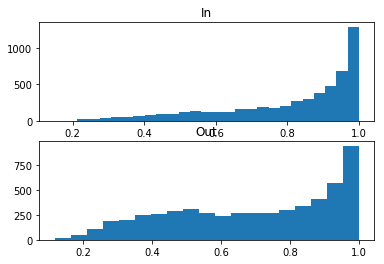

In [21]:
#attack net trained on nn shadow model on nn target
eval_attack_net(attack_net_nn, target_net, target_train_loader, target_out_loader, k)

In [ ]:
#attack net trained on nn shadow model on svm target, C=10, gamma=.1
# eval_attack_net(attack_net_nn, gen_svm, sv_target_train_loader, sv_target_out_loader, k)